In [126]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import resnet18

import time
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Prepare transformers and DataLoaders

In [127]:
transformTrainAug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainData = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transformTest)
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=64,shuffle=True, num_workers=2)

trainDataAug =  torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transformTrainAug)
trainLoaderAug = torch.utils.data.DataLoader(trainDataAug, batch_size=64,shuffle=True, num_workers=2)

testData = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transformTest)
testLoader = torch.utils.data.DataLoader(testData, batch_size=64, shuffle=False, num_workers=2)

In [128]:
def trainModel(nnModel, trainLoader, optimizerMethod=optim.SGD, lossFunction=nn.CrossEntropyLoss(), lRate = 0.005, n_epochs = 10):
    optimizer = optimizerMethod(nnModel.parameters(), lRate, momentum=0.5)

    start = time.time()
    for epch in range(n_epochs): 
        # before each epoch DataLoader reshuffles 
        for idx,dataBatch in enumerate(trainLoader):
            input, labels = dataBatch
            
            # zeroing out the gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            output = nnModel(input)
            loss = lossFunction(output, labels)
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                print(f"Loss: {loss.item():.3f}  Epoch:{epch} Iteration:{idx}")
    
    end = time.time()
    return nnModel, end - start

def evalNN(nnModel, testLoader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            outputs = nnModel(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()

        return y_true, y_pred
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(x.shape[0], 16 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training Lenet without data augemented

In [129]:
trainedNet, meausured_time  = trainModel(LeNet(), trainLoader)
label_true, label_pred = evalNN(trainedNet, testLoader)
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":meausured_time}])

Loss: 2.298  Epoch:0 Iteration:0
Loss: 2.289  Epoch:0 Iteration:100
Loss: 2.263  Epoch:0 Iteration:200
Loss: 2.087  Epoch:0 Iteration:300
Loss: 1.492  Epoch:0 Iteration:400
Loss: 1.121  Epoch:0 Iteration:500
Loss: 0.905  Epoch:0 Iteration:600
Loss: 0.805  Epoch:0 Iteration:700
Loss: 0.603  Epoch:0 Iteration:800
Loss: 0.687  Epoch:0 Iteration:900
Loss: 0.858  Epoch:1 Iteration:0
Loss: 0.921  Epoch:1 Iteration:100
Loss: 0.586  Epoch:1 Iteration:200
Loss: 0.544  Epoch:1 Iteration:300
Loss: 0.777  Epoch:1 Iteration:400
Loss: 0.744  Epoch:1 Iteration:500
Loss: 0.708  Epoch:1 Iteration:600
Loss: 0.627  Epoch:1 Iteration:700
Loss: 0.605  Epoch:1 Iteration:800
Loss: 0.674  Epoch:1 Iteration:900
Loss: 0.638  Epoch:2 Iteration:0
Loss: 0.537  Epoch:2 Iteration:100
Loss: 0.819  Epoch:2 Iteration:200
Loss: 0.772  Epoch:2 Iteration:300
Loss: 0.453  Epoch:2 Iteration:400
Loss: 0.472  Epoch:2 Iteration:500
Loss: 0.596  Epoch:2 Iteration:600
Loss: 0.498  Epoch:2 Iteration:700
Loss: 0.562  Epoch:2 Itera

,Accuracy,Precision,Trainig time
0,0.8482,0.849599,94.215641


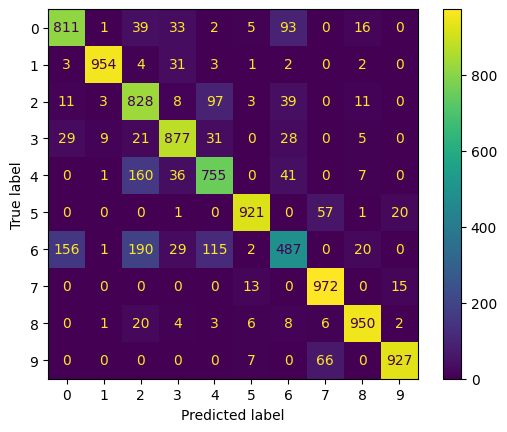

In [130]:
ConfusionMatrixDisplay.from_predictions(label_true, label_pred)
plt .title("Lenet5 standard")
plt.show()

### Training Lenet with data augemented

In [131]:
trainedNetAug, meausured_timeAug  = trainModel(LeNet(), trainLoaderAug)
label_true, label_pred = evalNN(trainedNetAug, testLoader)
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":meausured_timeAug}])

Loss: 2.293  Epoch:0 Iteration:0
Loss: 2.298  Epoch:0 Iteration:100
Loss: 2.302  Epoch:0 Iteration:200
Loss: 2.296  Epoch:0 Iteration:300
Loss: 2.287  Epoch:0 Iteration:400
Loss: 2.276  Epoch:0 Iteration:500
Loss: 2.240  Epoch:0 Iteration:600
Loss: 2.207  Epoch:0 Iteration:700
Loss: 2.081  Epoch:0 Iteration:800
Loss: 1.893  Epoch:0 Iteration:900
Loss: 1.922  Epoch:1 Iteration:0
Loss: 1.604  Epoch:1 Iteration:100
Loss: 1.417  Epoch:1 Iteration:200
Loss: 1.088  Epoch:1 Iteration:300
Loss: 1.108  Epoch:1 Iteration:400
Loss: 1.086  Epoch:1 Iteration:500
Loss: 1.035  Epoch:1 Iteration:600
Loss: 1.148  Epoch:1 Iteration:700
Loss: 0.795  Epoch:1 Iteration:800
Loss: 1.198  Epoch:1 Iteration:900
Loss: 1.035  Epoch:2 Iteration:0
Loss: 0.922  Epoch:2 Iteration:100
Loss: 0.947  Epoch:2 Iteration:200
Loss: 1.219  Epoch:2 Iteration:300
Loss: 0.832  Epoch:2 Iteration:400
Loss: 0.753  Epoch:2 Iteration:500
Loss: 0.900  Epoch:2 Iteration:600
Loss: 0.941  Epoch:2 Iteration:700
Loss: 0.776  Epoch:2 Itera

,Accuracy,Precision,Trainig time
0,0.7759,0.774057,124.361305


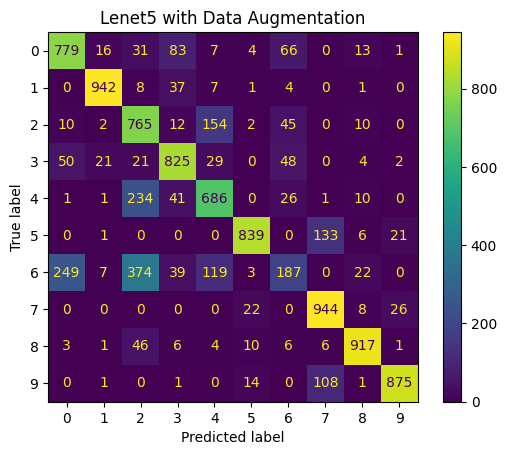

In [133]:
ConfusionMatrixDisplay.from_predictions(label_true, label_pred)
plt.title("Lenet5 with Data Augmentation")
plt.show()